# Point Cloud Classification with PointNet

In [1]:
#This is an implementation of PointNet with weighted CE loss(way 2)
#The architecture is same as in baseline model(only a weighted CE loss is implied)
#https://ai.stackexchange.com/questions/20249/how-are-weights-for-weighted-x-entropy-loss-on-imbalanced-data-calculated

In [2]:
#This is an implementation of PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation using PyTorch.
import os
import glob
import trimesh
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import math
import random
import torch.nn as nn
import torch
import torch.nn.functional as F
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
import time
import plotly.graph_objects as go




In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Data Analysis
## Visualize Cloud Point Dataset

In [59]:
CLASS_MAP={}
class_map=[]
with open("shape_names.txt") as f:
    for i,line in enumerate(f):
        key = i 
        val = line.split()
        CLASS_MAP[int(key)] = val
        class_map.append(val)

print (CLASS_MAP)

{0: ['airplane'], 1: ['bathtub'], 2: ['bed'], 3: ['bench'], 4: ['bookshelf'], 5: ['bottle'], 6: ['bowl'], 7: ['car'], 8: ['chair'], 9: ['cone'], 10: ['cup'], 11: ['curtain'], 12: ['desk'], 13: ['door'], 14: ['dresser'], 15: ['flower_pot'], 16: ['glass_box'], 17: ['guitar'], 18: ['keyboard'], 19: ['lamp'], 20: ['laptop'], 21: ['mantel'], 22: ['monitor'], 23: ['night_stand'], 24: ['person'], 25: ['piano'], 26: ['plant'], 27: ['radio'], 28: ['range_hood'], 29: ['sink'], 30: ['sofa'], 31: ['stairs'], 32: ['stool'], 33: ['table'], 34: ['tent'], 35: ['toilet'], 36: ['tv_stand'], 37: ['vase'], 38: ['wardrobe'], 39: ['xbox']}


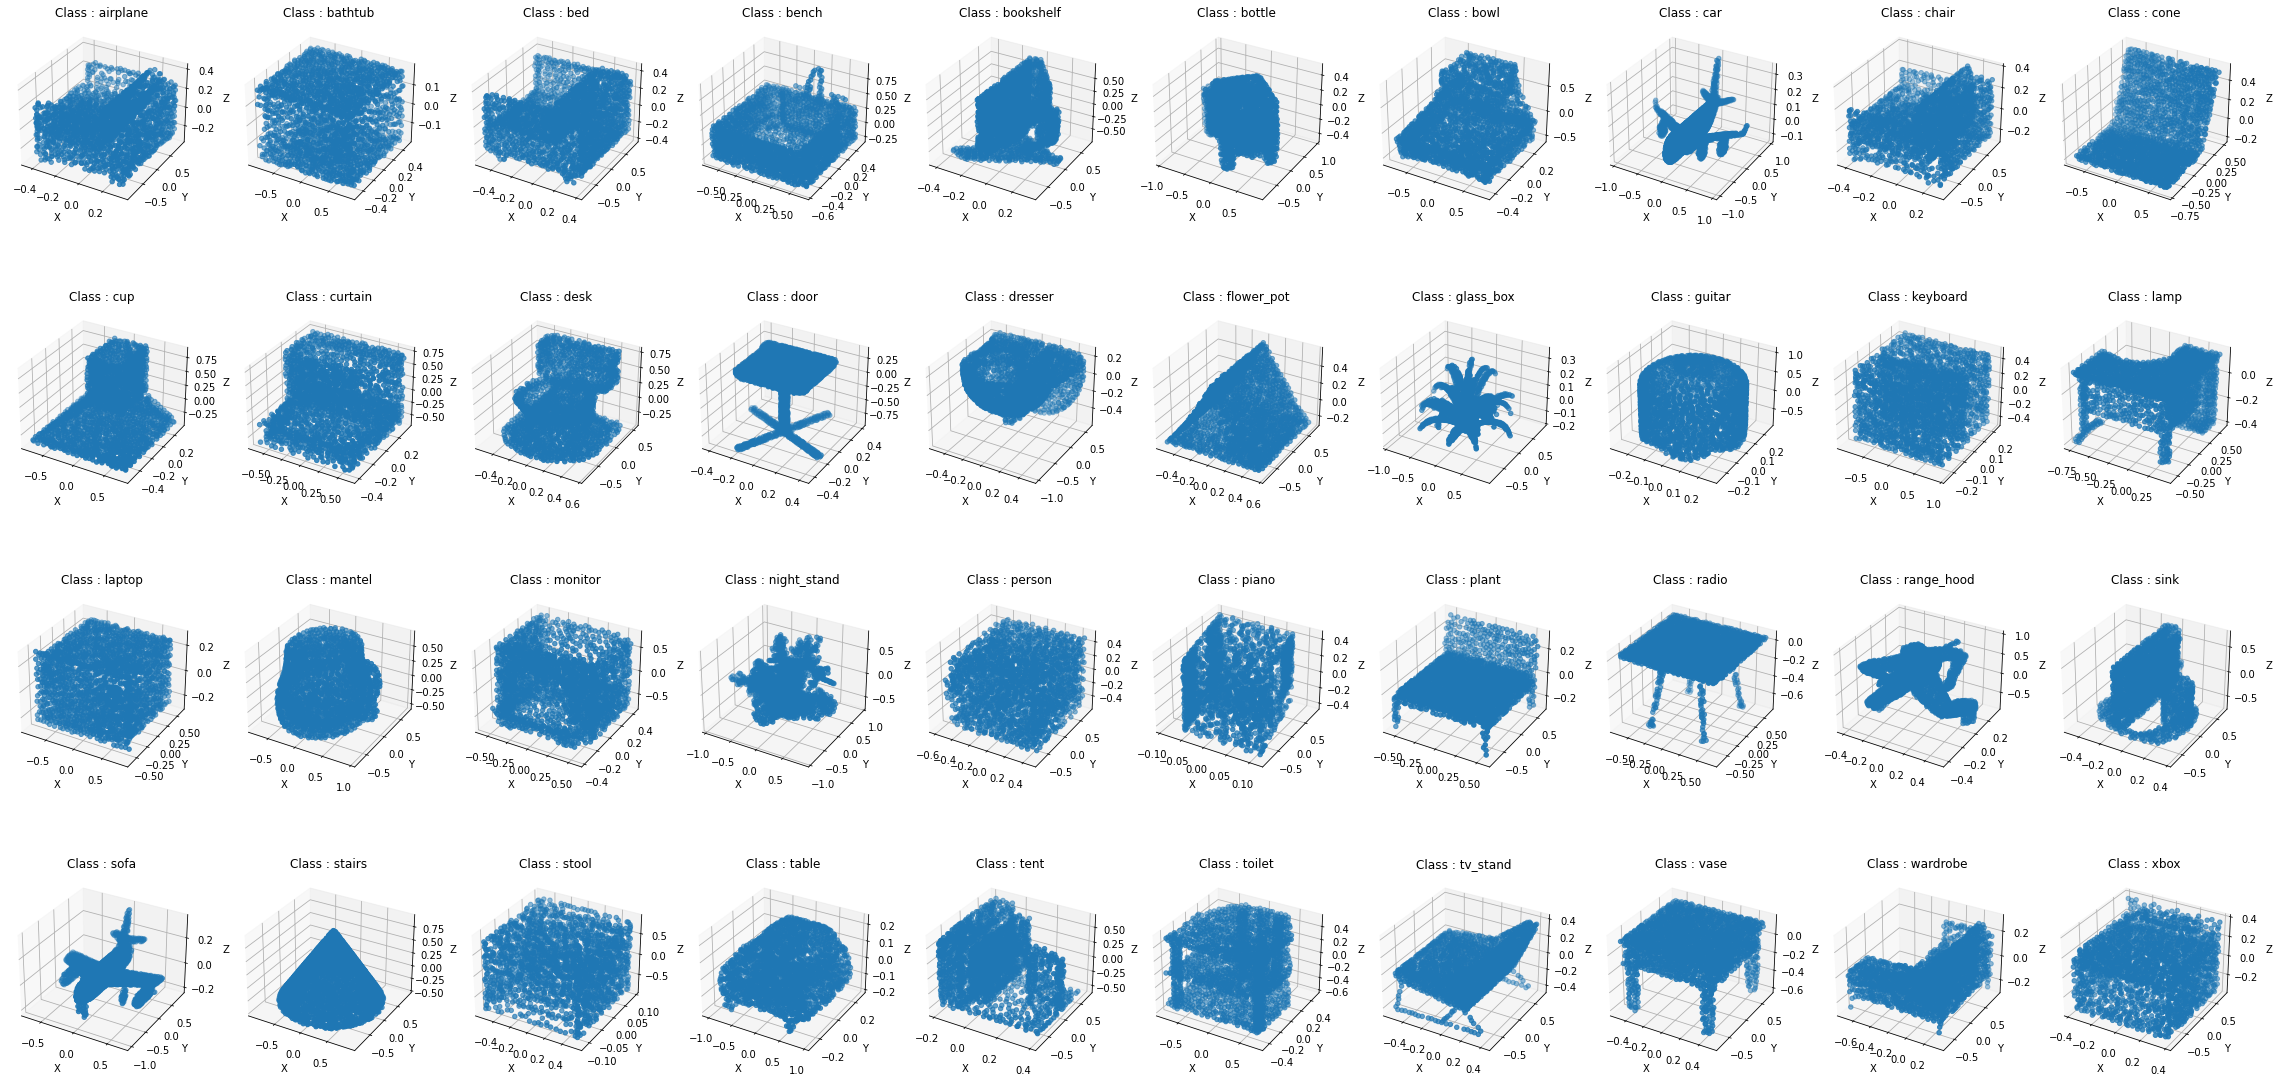

In [60]:
#Before diving into performing deep learning tasks on point cloud data, it is important to understand how the data in question looks like. 
#Thus, I plot 3D projection of point clouds to visualize how they represent common objects(in the 40 classes).
train_points = np.load('train/coors.npy')
test_points = np.load('test/coors.npy')
train_labels= np.load('train/labels.npy')
test_labels= np.load('test/labels.npy')

#1st index of each class label
unique_cloud_idx1 = [(train_labels.tolist()).index(i) for i in range(40)]
f, axs = plt.subplots(4,10,figsize=(40,20))
for i,idx in enumerate(unique_cloud_idx1):
    cloud_id = train_labels[idx]
    # coordinates
    x = train_points[cloud_id, :,0]
    y = train_points[cloud_id,:, 2]
    z = train_points[cloud_id,:, 1]
    ax = plt.subplot(4,10,i+1,projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Class : '+ (CLASS_MAP[i])[0])
    ax.scatter(x, y, z, cmap=plt.hot())
    # ax.set_axis_off()

plt.show()

In [8]:
len(train_labels.tolist())

9840

In [8]:
import pandas as pd
import collections
from collections import Counter
#is it a balanced dataset?
occurrences = collections.Counter(train_labels.tolist())
occurrences.most_common()

df = pd.DataFrame.from_records(list(dict(occurrences).items()), columns=['Class','count'])
df.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Class,30,27,29,22,7,28,0,20,35,32,...,37,23,15,6,3,38,1,13,19,39
count,680,104,128,465,197,115,625,149,344,90,...,475,200,149,64,173,87,106,109,124,103


In [9]:
df = df.sort_values(by=['Class'])
from IPython.display import display, HTML
display(HTML(df.to_html(index=False)))

Class,count
0,625
1,106
2,515
3,173
4,572
5,335
6,64
7,197
8,889
9,167


In [10]:
occurrences = collections.Counter(train_labels.tolist())
occurrences.most_common()
counter=sorted(occurrences.items())
type(occurrences)

collections.Counter

In [11]:
625/9840

0.06351626016260163

In [12]:
# class_list = df['Class'].tolist()
# freq_list = df['count'].tolist()

#we dun use this weight list(which based on % of sample of each class over total samples) for this weighted_CE_loss2 
# weight_list=[]
# for k,v in sorted(occurrences.items()):
#     per = v / len(train_labels) * 100
#     print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
#     weight_list.append(per)

Class=0, n=625 (6.352%)
Class=1, n=106 (1.077%)
Class=2, n=515 (5.234%)
Class=3, n=173 (1.758%)
Class=4, n=572 (5.813%)
Class=5, n=335 (3.404%)
Class=6, n=64 (0.650%)
Class=7, n=197 (2.002%)
Class=8, n=889 (9.035%)
Class=9, n=167 (1.697%)
Class=10, n=79 (0.803%)
Class=11, n=137 (1.392%)
Class=12, n=200 (2.033%)
Class=13, n=109 (1.108%)
Class=14, n=200 (2.033%)
Class=15, n=149 (1.514%)
Class=16, n=171 (1.738%)
Class=17, n=155 (1.575%)
Class=18, n=145 (1.474%)
Class=19, n=124 (1.260%)
Class=20, n=149 (1.514%)
Class=21, n=284 (2.886%)
Class=22, n=465 (4.726%)
Class=23, n=200 (2.033%)
Class=24, n=88 (0.894%)
Class=25, n=231 (2.348%)
Class=26, n=239 (2.429%)
Class=27, n=104 (1.057%)
Class=28, n=115 (1.169%)
Class=29, n=128 (1.301%)
Class=30, n=680 (6.911%)
Class=31, n=124 (1.260%)
Class=32, n=90 (0.915%)
Class=33, n=392 (3.984%)
Class=34, n=163 (1.657%)
Class=35, n=344 (3.496%)
Class=36, n=267 (2.713%)
Class=37, n=475 (4.827%)
Class=38, n=87 (0.884%)
Class=39, n=103 (1.047%)


In [16]:
class_list = df['Class'].tolist()
freq_list = df['count'].tolist()
freq_list
len(train_labels)

9840

In [17]:
# Create weight tensor for weighted nn.CrossEntropyLoss
weight_list=[]
for i in range(40):
    weight_for_a_class = (1 / freq_list[i]) * len(train_labels)/40
    weight_list.append(weight_for_a_class)

weights = torch.tensor(weight_list, dtype=torch.float32)
print(weights)
class_weights = torch.FloatTensor(weights).cuda()
Criterion = nn.CrossEntropyLoss(weight=class_weights)

tensor([0.3936, 2.3208, 0.4777, 1.4220, 0.4301, 0.7343, 3.8438, 1.2487, 0.2767,
        1.4731, 3.1139, 1.7956, 1.2300, 2.2569, 1.2300, 1.6510, 1.4386, 1.5871,
        1.6966, 1.9839, 1.6510, 0.8662, 0.5290, 1.2300, 2.7955, 1.0649, 1.0293,
        2.3654, 2.1391, 1.9219, 0.3618, 1.9839, 2.7333, 0.6276, 1.5092, 0.7151,
        0.9213, 0.5179, 2.8276, 2.3883])


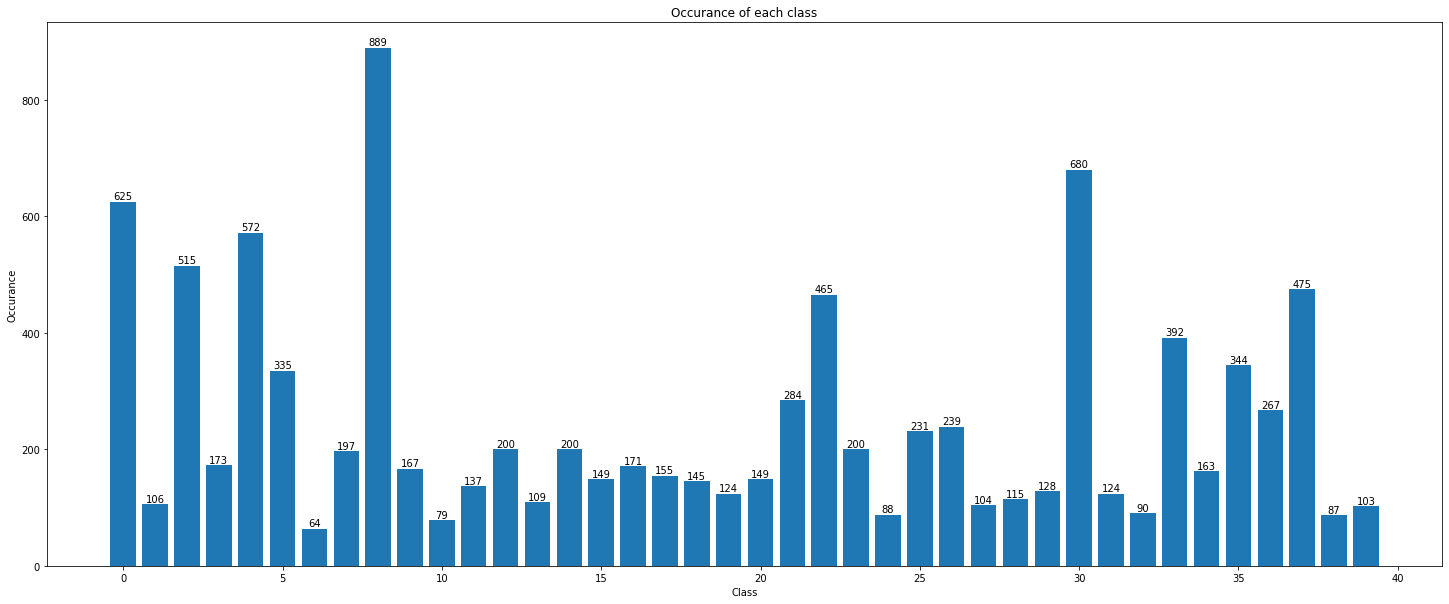

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10)) 
# Plot the bar graph
plot = plt.bar(class_list, freq_list)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,1.002*height,'%d' % int(height), ha='center', va='bottom')
 
plt.title("Occurance of each class")
plt.xlabel("Class")
plt.ylabel("Occurance")
 
# Display the graph on the screen
plt.show()

# Augmentation

In [20]:
# Normalize the pointcloud to a unit sphere
"""
    Pointcloud data will now have zero mean and will be centered around the origin, normalized to a unit sphere.
    pointcloud is of shape (n,3) where n is the number of points
"""
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud
normalize_pointcloud = Normalize()
pointcloud = normalize_pointcloud(train_points[1023]) # Normalize the pointcloud to a unit sphere
print(pointcloud.shape) 
# fig=go.Figure(data=[go.Scatter3d(x=pointcloud[:,0],y=pointcloud[:,2],z=pointcloud[:,1],mode='markers')])
# fig.show()

(2048, 3)


In [21]:
#Rotation
"""
    Function to randomly rotate a pointcloud (object) by an angle theta along the z axis, this is useful to make a deep learning model view invariant.
    Explanation can be found at https://en.wikipedia.org/wiki/Rotation_matrix #Basic_rotations.
    pointcloud is of shape (n,3) where n is the number of points
"""
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
rot_pointcloud = RandRotation_z()(train_points[1023])
print(rot_pointcloud.shape) 
# fig=go.Figure(data=[go.Scatter3d(x=rot_pointcloud[:,0],y=rot_pointcloud[:,2],z=rot_pointcloud[:,1],mode='markers')])
# fig.show()


(2048, 3)


In [22]:
#Adding noise
"""
    To make a deep learning model robust to variances in distributions of input data, a slight noise is added to the original pointcloud.
    Jitter the position of each points by a Gaussian noise with zero mean and 0.02 standard deviation.
"""
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

    
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)#(train_points[1023]) 
print(noisy_rot_pointcloud.shape) 
# fig=go.Figure(data=[go.Scatter3d(x=noisy_rot_pointcloud[:,0],y=noisy_rot_pointcloud[:,2],z=noisy_rot_pointcloud[:,1],mode='markers')])
# fig.show()


(2048, 3)


In [23]:
class shuffle(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        # shuffle points
        #This function only shuffles the array along the first axis of a multi-dimensional array. The order of sub-arrays is changed but their contents remains the same.
        np.random.shuffle(pointcloud)
        shuffle_pointcloud = pointcloud
        return shuffle_pointcloud

    
shuffle_noisy_rot_pointcloud = shuffle()(noisy_rot_pointcloud)#(train_points[1023]) 
print(shuffle_noisy_rot_pointcloud.shape) 
# fig=go.Figure(data=[go.Scatter3d(x=shuffle_noisy_rot_pointcloud[:,0],y=shuffle_noisy_rot_pointcloud[:,2],z=shuffle_noisy_rot_pointcloud[:,1],mode='markers')])
# fig.show()

(2048, 3)


In [24]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [27]:
train_transforms = transforms.Compose([
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])
test_transforms = transforms.Compose([
                    Normalize(),
                    ToTensor()
                    ])

In [28]:
class PointCloudData(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.points = np.load(dataset_dir+'coors.npy')
        self.labels= np.load(dataset_dir+'labels.npy')
        print(self.labels)
        self.transforms = transform 
    
    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        pointcloud = self.transforms(self.points[idx])
        return {'pointcloud': pointcloud, 
                'category': self.labels[idx]}

In [ ]:
train_ds = PointCloudData('train/', transform=train_transforms)
test_ds = PointCloudData('test/',transform=test_transforms)

In [31]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

# Model

To deal with unordered input set, key to the PointNet approach is the use of a single symmetric function, max pooling. Effectively the network learns a set of optimization functions/criteria that select interesting or informative points of the point cloud and encode the reason for their selection. The final fully connected layers of the network aggregate these learnt optimal values into the global descriptor for the entire shape as mentioned above (shape classification) or are used to predict per point labels (shape segmentation). The input format is easy to apply rigid or affine transformations to, as each point transforms independently. Thus we can add a data-dependent spatial transformer network that attempts to canonicalize the data before the PointNet processes them, so as to further improve the results.

In [32]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
       

    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        #print('input : ',input.shape)
        x = F.relu(self.bn1(self.conv1(input)))
        #print('after conv1 : ',x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
        #print('after conv2 : ',x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        #print('after conv3 : ',x.shape)
        pool = nn.MaxPool1d(x.size(-1))(x)
        #print('after pool : ',pool.shape)
        flat = nn.Flatten(1)(pool)
        #print('after flat : ',flat.shape)
        x = F.relu(self.bn4(self.fc1(flat)))
        #print('after fc1 : ',x.shape)
        x = F.relu(self.bn5(self.fc2(x)))
        #print('after fc2 : ',x.shape)

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if x.is_cuda:
            init=init.cuda()   
        matrix = self.fc3(x).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
    def forward(self, input):
        matrix3x3 = self.input_transform(input) # here, input is of shape (bs,3,n)
        input = torch.transpose(input,1,2)# input is now (bs,n,3)
        # apply input transform (batch matrix multiplication) 
        x = torch.bmm(input, matrix3x3).transpose(1,2)
        x = F.relu(self.bn1(self.conv1(x)))
        
        # similarly for the feature space
        # we apply input transform
        matrix64x64 = self.feature_transform(x)
        x = torch.transpose(x,1,2)
        x = torch.bmm(x, matrix64x64).transpose(1,2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = nn.MaxPool1d(x.size(-1))(x)
        output = nn.Flatten(1)(x)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)    
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        x, matrix3x3, matrix64x64 = self.transform(input)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        # output = (self.fc3(x))#self.logsoftmax
        output = self.logsoftmax(self.fc3(x))
        return output, matrix3x3, matrix64x64

In [33]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    #criterion = torch.nn.NLLLoss()
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [34]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Training

In [35]:
bs=32
epochs = 300
lr = 0.001
save_every = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
model = PointNet()
model.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.5)
early_stopping = EarlyStopping(patience=20, verbose=True)
writer = SummaryWriter('runs/experiment_baseline_weighted_CE_loss2')

In [38]:
def train(train_loader, test_loader=None,  epochs=15):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        av_tr_loss = 0
        train_acc = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].type(torch.LongTensor).to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            av_tr_loss += loss.item()
            
            # print statistics
            running_loss += loss.item()
            acc = torch.sum(torch.argmax(outputs.data,dim = 1) == labels)
            train_acc += acc
            if i % 100 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f, accuracy: %.2f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss/ 100, 100*acc.item()/labels.size()[0]))
                    running_loss = 0.0

        model.eval()
        correct = total = 0
        av_test_loss = 0
        test_acc = 0
        # validation
        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].type(torch.LongTensor).to(device)
                    outputs, m3x3, m64x64 = model(inputs.transpose(1,2))
                    loss_test = pointnetloss(outputs, labels, m3x3, m64x64)
                    av_test_loss += loss_test.item()
                    test_acc += torch.sum(torch.argmax(outputs.data,dim = 1) == labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Test accuracy: %d %%' % val_acc)

        writer.add_scalar('Test Loss',av_test_loss/(len(test_ds)//bs),epoch)
        writer.add_scalar('Test acc',test_acc.item()/len(test_ds),epoch)
        writer.add_scalar('Train Loss',av_tr_loss/(len(train_ds)//bs),epoch)
        writer.add_scalar('Train acc',train_acc.item()/len(train_ds),epoch)
        train_losses.append(av_tr_loss/(len(train_ds)//bs))
        test_losses.append(av_test_loss/(len(test_ds)//bs))
        train_accs.append(train_acc.item()/len(train_ds))
        test_accs.append(test_acc.item()/len(test_ds))
        print("TESTING")       
        print("Epoch [{}/{}] --> Testing Loss:{:.3f}, Testing Accuracy:{:.2f}\n".format(epoch+1,epochs,av_test_loss/(len(test_ds)//bs), 100*test_acc.item()/len(test_ds)))
        print("TRAINING")
        print("Epoch [{}/{}] --> Training Loss:{:.3f}, Training Accuracy:{:.2f}\n".format(epoch+1,epochs,av_tr_loss/(len(train_ds)//bs), 100*train_acc.item()/len(train_ds)))
        
        # save the model
        if (epoch+1)%save_every == 0:
            print("SAVING MODEL CHECKPOINT")
            torch.save(model.state_dict(), "ckpt/baseline_weighted_CE_loss2_ckpt/save_baseline_weighted_CE_loss2"+str(epoch)+".pth")
        
        #end of one epoch
        mean_loss = (av_test_loss/(len(test_ds)//bs))
        early_stopping(mean_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            torch.save(model.state_dict(), 'early_stop_ckpt/baseline_weighted_CE_loss2_early_stop_model.pth')
            break #early stopping applied

    writer.flush()
    return train_losses,test_losses,train_accs,test_accs   

In [39]:
train_losses,test_losses,train_accs,test_accs=train(train_loader, test_loader, 250)

[Epoch: 1, Batch:   10 /  308], loss: 0.375, accuracy: 3.12
[Epoch: 1, Batch:  110 /  308], loss: 3.428, accuracy: 3.12
[Epoch: 1, Batch:  210 /  308], loss: 3.042, accuracy: 18.75
Test accuracy: 20 %
TESTING
Epoch [1/250] --> Testing Loss:2.883, Testing Accuracy:20.71

TRAINING
Epoch [1/250] --> Training Loss:3.133, Training Accuracy:16.68

Validation loss decreased (inf --> 2.882869).  Saving model ...
[Epoch: 2, Batch:   10 /  308], loss: 0.284, accuracy: 6.25
[Epoch: 2, Batch:  110 /  308], loss: 2.758, accuracy: 28.12
[Epoch: 2, Batch:  210 /  308], loss: 2.647, accuracy: 28.12
Test accuracy: 28 %
TESTING
Epoch [2/250] --> Testing Loss:2.860, Testing Accuracy:28.69

TRAINING
Epoch [2/250] --> Training Loss:2.662, Training Accuracy:27.54

Validation loss decreased (2.882869 --> 2.860272).  Saving model ...
[Epoch: 3, Batch:   10 /  308], loss: 0.262, accuracy: 18.75
[Epoch: 3, Batch:  110 /  308], loss: 2.435, accuracy: 43.75
[Epoch: 3, Batch:  210 /  308], loss: 2.383, accuracy: 3

In [ ]:
308*32 #9840 for training

# Inference

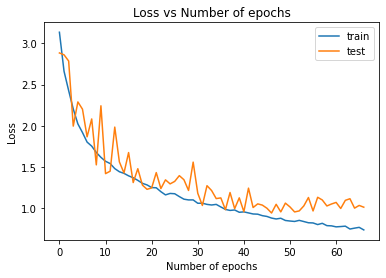

In [40]:
plt.plot(train_losses,label = 'train')
plt.plot(test_losses,label = 'test')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

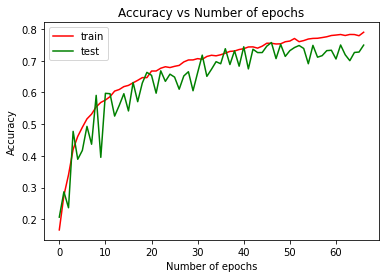

In [41]:
plt.plot(train_accs,label = 'train', color= 'red')
plt.plot(test_accs,label = 'test', color = 'green')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix

In [51]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('baseline_weighted_CE_loss2_early_stop_model.pth'))
pointnet.eval();

In [53]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   78]
Batch [   2 /   78]
Batch [   3 /   78]
Batch [   4 /   78]
Batch [   5 /   78]
Batch [   6 /   78]
Batch [   7 /   78]
Batch [   8 /   78]
Batch [   9 /   78]
Batch [  10 /   78]
Batch [  11 /   78]
Batch [  12 /   78]
Batch [  13 /   78]
Batch [  14 /   78]
Batch [  15 /   78]
Batch [  16 /   78]
Batch [  17 /   78]
Batch [  18 /   78]
Batch [  19 /   78]
Batch [  20 /   78]
Batch [  21 /   78]
Batch [  22 /   78]
Batch [  23 /   78]
Batch [  24 /   78]
Batch [  25 /   78]
Batch [  26 /   78]
Batch [  27 /   78]
Batch [  28 /   78]
Batch [  29 /   78]
Batch [  30 /   78]
Batch [  31 /   78]
Batch [  32 /   78]
Batch [  33 /   78]
Batch [  34 /   78]
Batch [  35 /   78]
Batch [  36 /   78]
Batch [  37 /   78]
Batch [  38 /   78]
Batch [  39 /   78]
Batch [  40 /   78]
Batch [  41 /   78]
Batch [  42 /   78]
Batch [  43 /   78]
Batch [  44 /   78]
Batch [  45 /   78]
Batch [  46 /   78]
Batch [  47 /   78]
Batch [  48 /   78]
Batch [  49 /   78]
Batch [  50 /   78]


In [54]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[97,  0,  0, ...,  0,  0,  0],
       [ 0, 34,  1, ...,  0,  0,  1],
       [ 0,  0, 94, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 29,  2,  0],
       [ 0,  0,  0, ...,  0, 12,  1],
       [ 0,  0,  1, ...,  0,  1, 11]])

In [55]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

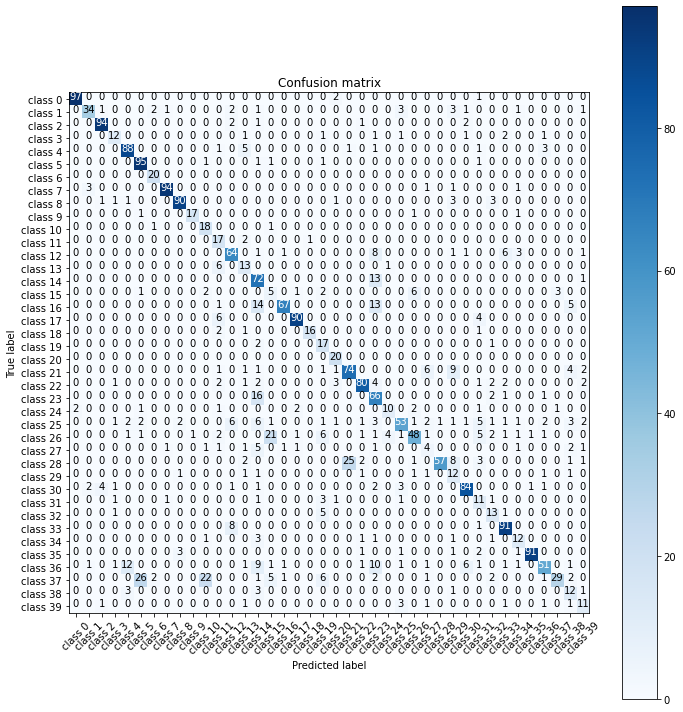

In [56]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, ['class '+str(s) for s in list(range(40))])

In [57]:
from sklearn.metrics import classification_report
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(all_labels, all_preds)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       100
           1       0.85      0.68      0.76        50
           2       0.93      0.94      0.94       100
           3       0.63      0.60      0.62        20
           4       0.82      0.88      0.85       100
           5       0.75      0.95      0.84       100
           6       0.80      1.00      0.89        20
           7       0.97      0.94      0.95       100
           8       0.94      0.90      0.92       100
           9       0.94      0.85      0.89        20
          10       0.40      0.90      0.55        20
          11       0.42      0.85      0.57        20
          12       0.77      0.74      0.76        86
          13       0.43      0.65      0.52        20
          14       0.51      0.84      0.63        86
          15       0.14      0.25      0.18        20
          16       0.94      0.67      0.78       100
 

# Visualize The Predictions

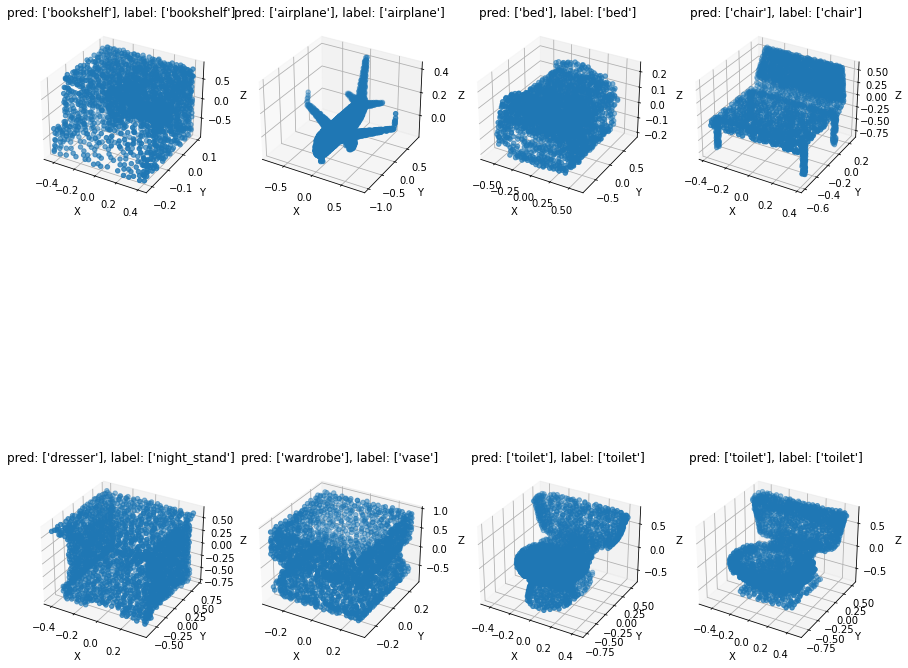

In [61]:
train_points = np.load('train/coors.npy')
test_points = np.load('test/coors.npy')
train_labels= np.load('train/labels.npy')
test_labels= np.load('test/labels.npy')
#visualise the first 8 test prediction
f, axs = plt.subplots(2,4,figsize=(15,15))
for i in range(8):
    # coordinates
    x = test_points[i, :,0]
    y = test_points[i,:, 2]
    z = test_points[i,:, 1]
    ax = plt.subplot(2,4,i+1,projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(
    "pred: {:}, label: {:}".format(
        CLASS_MAP[all_preds[i]], CLASS_MAP[all_labels[i]]
    ))
    ax.scatter(x, y, z, cmap=plt.hot())
    # ax.set_axis_off()

plt.show()